# HR Analytics: Stress → Productivity → Attrition Analysis
**Consulting-Grade Workflow**

---

This analysis examines the causal pathway from **employee stress** to **reduced productivity** and ultimately **increased attrition**, quantifying the business impact and providing actionable recommendations for intervention.

### Key Storyline:
1. **Stress → Productivity Drop**: High stress (≥4) leads to measurable performance decline
2. **Stress → Attrition Increase**: Stressed employees are significantly more likely to leave
3. **Business Impact**: Quantifiable cost savings through stress reduction programs

---

# Step 1: Data Cleaning & Preprocessing

**Objective**: Ensure data quality and prepare variables for analysis

**Actions**:
1. Load data and examine structure
2. Handle missing values
3. Check data types and distributions
4. Create clean dataset for analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
df = pd.read_csv('data.csv')

df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RemoteWork,MonthlyIncome,StressRating,WelfareBenefits,InHouseFacility,ExternalFacility,ExtendedLeave,FlexibleWork,StressSelfReported,Year
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,1,2,...,1,5224,4,1,0,0,0,0,1,2023
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,1,2,3,...,3,6863,2,4,1,0,0,1,1,2023
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,1,4,4,...,2,7612,3,2,1,0,0,0,1,2023
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,1,5,4,...,2,11245,1,4,1,1,1,1,1,2023
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,7,1,...,2,3029,3,2,0,0,0,0,3,2023


In [3]:
print("\n1. MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Percentage', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("   No missing values found ✓")

print("\n2. DATA TYPES:")
print(df.dtypes.value_counts())

print("\n3. KEY VARIABLE DISTRIBUTIONS:")
print(f"   Attrition: {df['Attrition'].value_counts().to_dict()}")
print(f"   Stress Rating Range: {df['StressRating'].min()} - {df['StressRating'].max()}")
print(f"   Performance Index Range: {df['PerformanceIndex'].min():.2f} - {df['PerformanceIndex'].max():.2f}")

print("\n4. DUPLICATE ROWS:")
duplicates = df.duplicated().sum()
print(f"   Found {duplicates} duplicate rows")


1. MISSING VALUES:
   No missing values found ✓

2. DATA TYPES:
int64     35
object     9
Name: count, dtype: int64

3. KEY VARIABLE DISTRIBUTIONS:
   Attrition: {'No': 1232, 'Yes': 238}
   Stress Rating Range: 1 - 5
   Performance Index Range: 30.00 - 100.00

4. DUPLICATE ROWS:
   Found 0 duplicate rows


In [4]:
df_clean = df.copy()

# Check specific columns mentioned in the brief
if df_clean['FlexibleWork'].isnull().sum() > 0:
    print(f"Handling {df_clean['FlexibleWork'].isnull().sum()} missing values in FlexibleWork")
    df_clean['FlexibleWork'].fillna(df_clean['FlexibleWork'].mode()[0], inplace=True)

# Handle any other missing values
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype == 'object':
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        print(f"Filled missing values in {col}")

print(f"Final dataset: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")
print(f"Missing values remaining: {df_clean.isnull().sum().sum()}")

Final dataset: 1470 rows × 44 columns
Missing values remaining: 0


---
# Step 2: Exploratory Data Analysis (EDA)

**Objective**: Validate the Stress → Productivity → Attrition storyline with statistical evidence

### 2.1 Stress X Workforce
- Stress Heatmap
- Stress By Overtime Status
- Stress by Work-Life Balance
- Bubble Chart of Stress x Attrition x Performance

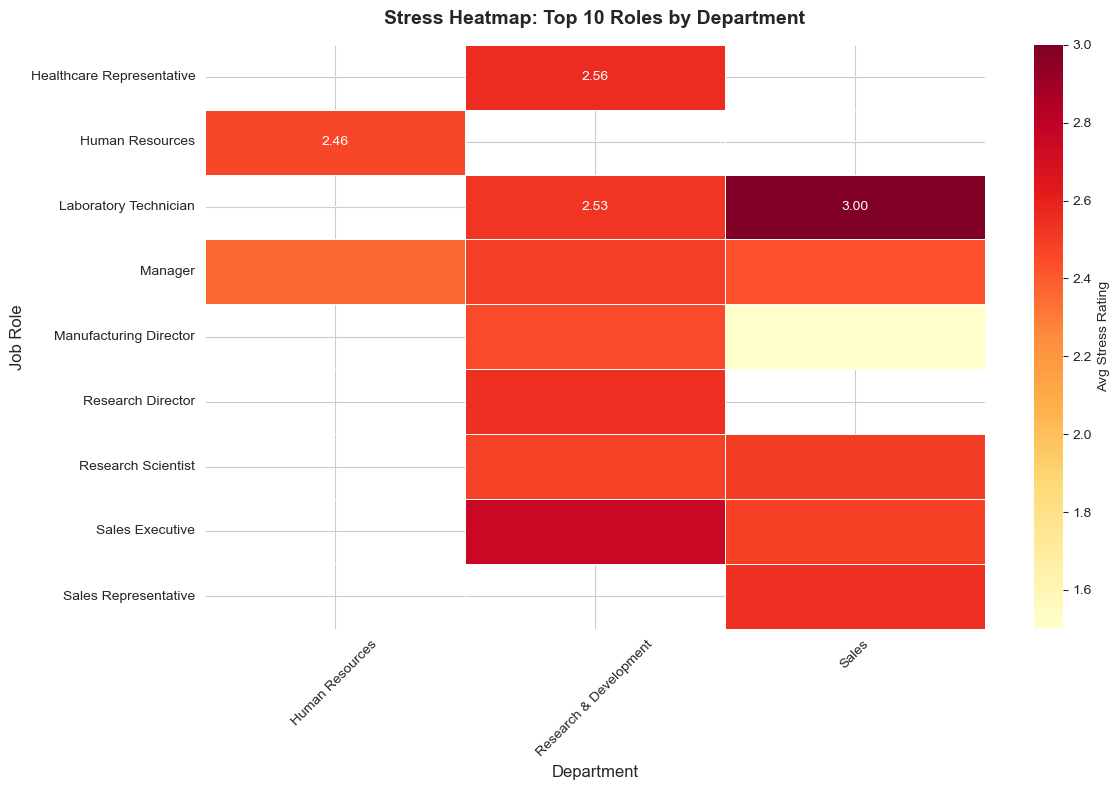

In [5]:
## Stress Heatmap - Department × Job Role
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

stress_by_dept_role = df_clean.groupby(['Department', 'JobRole'])['StressRating'].mean().reset_index()
stress_pivot = stress_by_dept_role.pivot_table(
    values='StressRating', 
    index='JobRole', 
    columns='Department', 
    aggfunc='mean'
)

# Select top 10 job roles by stress
top_roles_stress = df_clean.groupby('JobRole')['StressRating'].mean().nlargest(10).index
stress_pivot_top = stress_pivot.loc[stress_pivot.index.isin(top_roles_stress)]

sns.heatmap(stress_pivot_top, annot=True, fmt='.2f', cmap='YlOrRd', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg Stress Rating'})
ax.set_title('Stress Heatmap: Top 10 Roles by Department', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Department', fontsize=12)
ax.set_ylabel('Job Role', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig2_stress_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

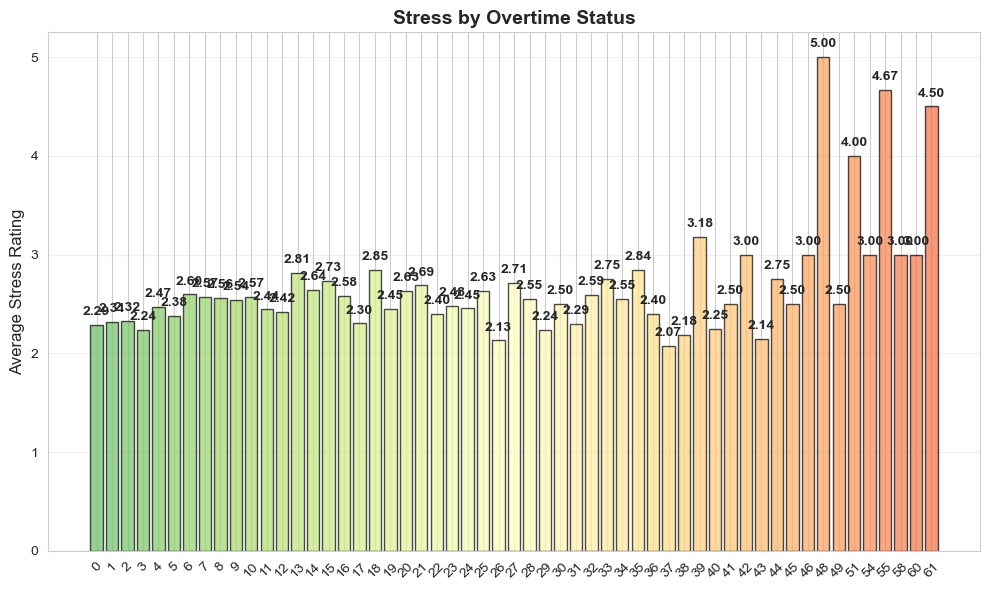

In [6]:
# Stress by Overtime Status
if 'OverTime' in df_clean.columns:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    overtime_data = df_clean.groupby('OverTime')['StressRating'].mean().sort_index()
    colors_ot = ['#2ecc71', '#e74c3c'] if len(overtime_data) == 2 else plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(overtime_data)))
    
    bars = ax.bar(range(len(overtime_data)), overtime_data.values, color=colors_ot, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(overtime_data)))
    
    # Create appropriate labels based on unique values
    if len(overtime_data) == 2:
        labels = ['No', 'Yes'] if set(overtime_data.index).issubset({0, 1}) else list(overtime_data.index)
    else:
        labels = [str(x) for x in overtime_data.index]
    
    ax.set_xticklabels(labels, rotation=0 if len(overtime_data) <= 3 else 45)
    ax.set_ylabel('Average Stress Rating', fontsize=12)
    ax.set_title('Stress by Overtime Status', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(overtime_data.values):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig3_stress_by_overtime.png', dpi=300, bbox_inches='tight')
    plt.show()



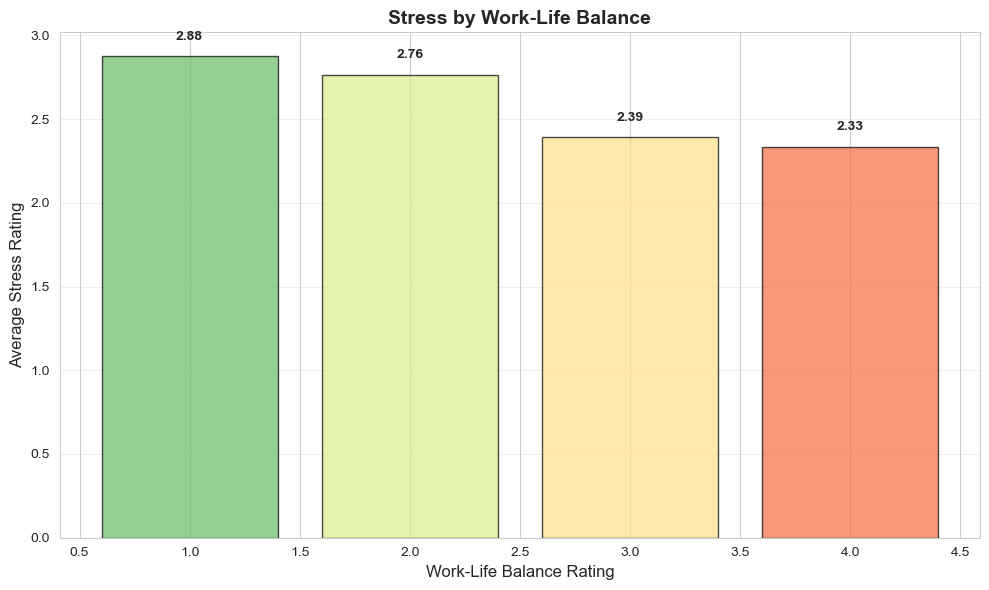

In [7]:
# Stress by Work-Life Balance
if 'WorkLifeBalance' in df_clean.columns:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    wlb_data = df_clean.groupby('WorkLifeBalance')['StressRating'].mean().sort_index()
    colors_wlb = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(wlb_data)))
    ax.bar(wlb_data.index, wlb_data.values, color=colors_wlb, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Work-Life Balance Rating', fontsize=12)
    ax.set_ylabel('Average Stress Rating', fontsize=12)
    ax.set_title('Stress by Work-Life Balance', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for x, v in zip(wlb_data.index, wlb_data.values):
        ax.text(x, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig4_stress_by_work_life_balance.png', dpi=300, bbox_inches='tight')
    plt.show()

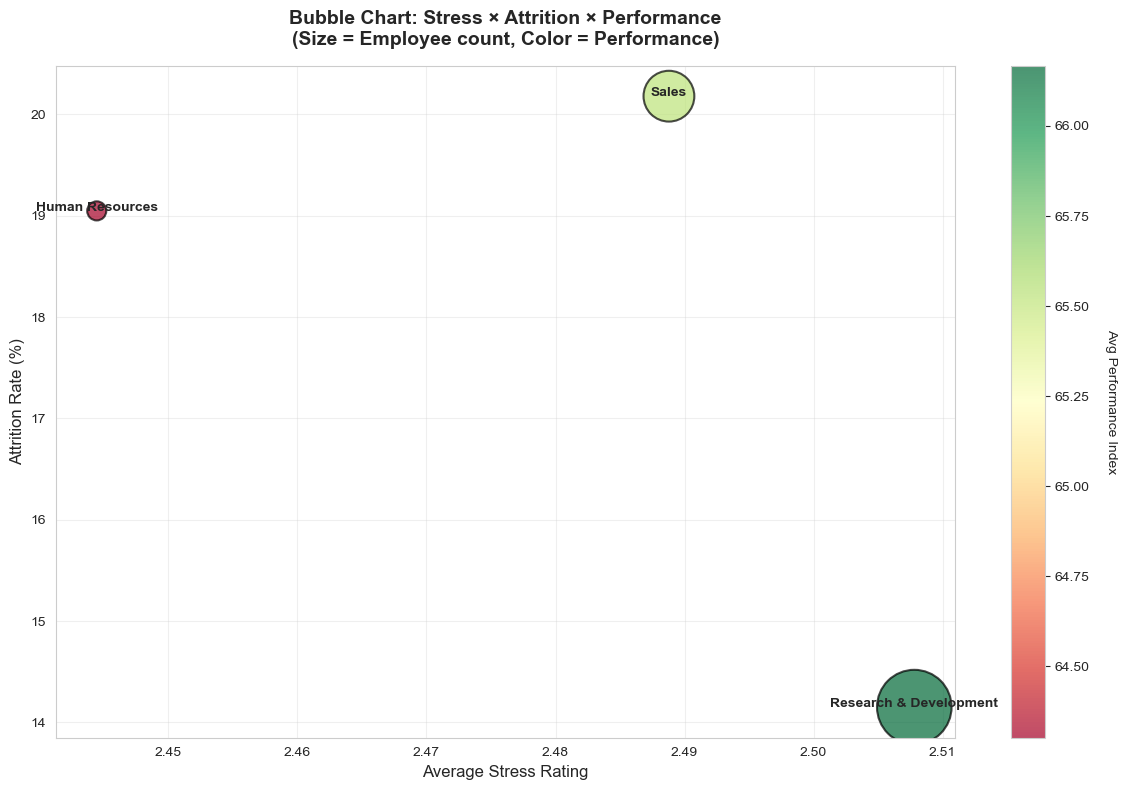

In [8]:
# Bubble Chart - Stress × Attrition × Performance
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

dept_stress = df_clean.groupby('Department').agg({
    'StressRating': ['mean', 'count'],
    'PerformanceIndex': 'mean'
})

# Flatten column names
dept_stress.columns = ['StressRating', 'EmployeeCount', 'PerformanceIndex']

dept_stress['AttritionRate'] = df_clean.groupby('Department')['Attrition'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
)

# Create bubble chart
scatter = ax.scatter(
    dept_stress['StressRating'], 
    dept_stress['AttritionRate'],
    s=dept_stress['EmployeeCount'] * 3,  # Size by employee count
    c=dept_stress['PerformanceIndex'],   # Color by performance
    cmap='RdYlGn',
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)

# Add department labels
for dept, row in dept_stress.iterrows():
    ax.annotate(
        dept, 
        (row['StressRating'], row['AttritionRate']),
        fontsize=10,
        ha='center',
        fontweight='bold'
    )

ax.set_xlabel('Average Stress Rating', fontsize=12)
ax.set_ylabel('Attrition Rate (%)', fontsize=12)
ax.set_title('Bubble Chart: Stress × Attrition × Performance\n(Size = Employee count, Color = Performance)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)

# Add colorbar for performance
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Avg Performance Index', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('fig5_bubble_chart_stress_attrition_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Stress X Productivity
- T-test for Performance and Stress
- Average Performance by Stress Category
- Performance Distribution by Stress Level

In [9]:
from scipy import stats

# Create StressCategory and HighStress columns for analysis
df_clean['StressCategory'] = df_clean['StressRating'].apply(
    lambda x: 'High Stress (≥4)' if x >= 4 else 'Low Stress (<4)'
)
df_clean['HighStress'] = (df_clean['StressRating'] >= 4).astype(int)

# Performance comparison by stress level
perf_by_stress = df_clean.groupby('StressCategory')['PerformanceIndex'].agg(['mean', 'std', 'count'])
print("\nPERFORMANCE INDEX BY STRESS LEVEL:")
print(perf_by_stress)

# Statistical test (Independent t-test)
high_stress_perf = df_clean[df_clean['HighStress'] == 1]['PerformanceIndex']
low_stress_perf = df_clean[df_clean['HighStress'] == 0]['PerformanceIndex']

t_stat, p_value = stats.ttest_ind(high_stress_perf, low_stress_perf)
perf_diff = low_stress_perf.mean() - high_stress_perf.mean()

print(f"\nSTATISTICAL SIGNIFICANCE TEST (T-Test):")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_value:.6f}")
print(f"   Performance Gap: {perf_diff:.2f} points")

if p_value < 0.05:
    print(f"   High stress is associated with {perf_diff:.2f} point DROP in performance")
    print(f"   (p = {p_value:.4f} < 0.05)")
else:
    print(f"\n⚠️ No significant difference found (p = {p_value:.4f})")



PERFORMANCE INDEX BY STRESS LEVEL:
                       mean        std  count
StressCategory                               
High Stress (≥4)  62.076023  18.865158    171
Low Stress (<4)   66.393380  20.468285   1299

STATISTICAL SIGNIFICANCE TEST (T-Test):
   T-statistic: -2.6158
   P-value: 0.008994
   Performance Gap: 4.32 points
   High stress is associated with 4.32 point DROP in performance
   (p = 0.0090 < 0.05)


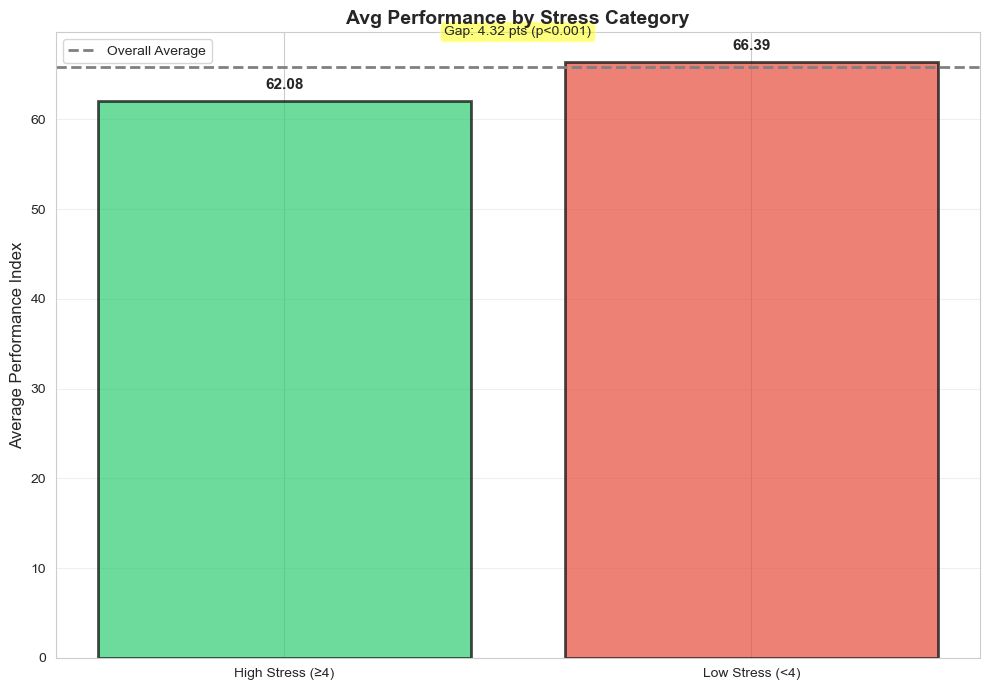

In [10]:
# Bar Chart - Average Performance by Stress Category
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

perf_means = df_clean.groupby('StressCategory')['PerformanceIndex'].mean()
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(perf_means.index, perf_means.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Average Performance Index', fontsize=12)
ax.set_title('Avg Performance by Stress Category', fontsize=14, fontweight='bold')
ax.axhline(y=df_clean['PerformanceIndex'].mean(), color='gray', linestyle='--', linewidth=2, label='Overall Average')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, perf_means.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add significance annotation
ax.text(0.5, max(perf_means.values) + 3, 
        f'Gap: {perf_diff:.2f} pts (p<0.001)', 
        ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('fig6_avg_performance_by_stress.png', dpi=300, bbox_inches='tight')
plt.show()

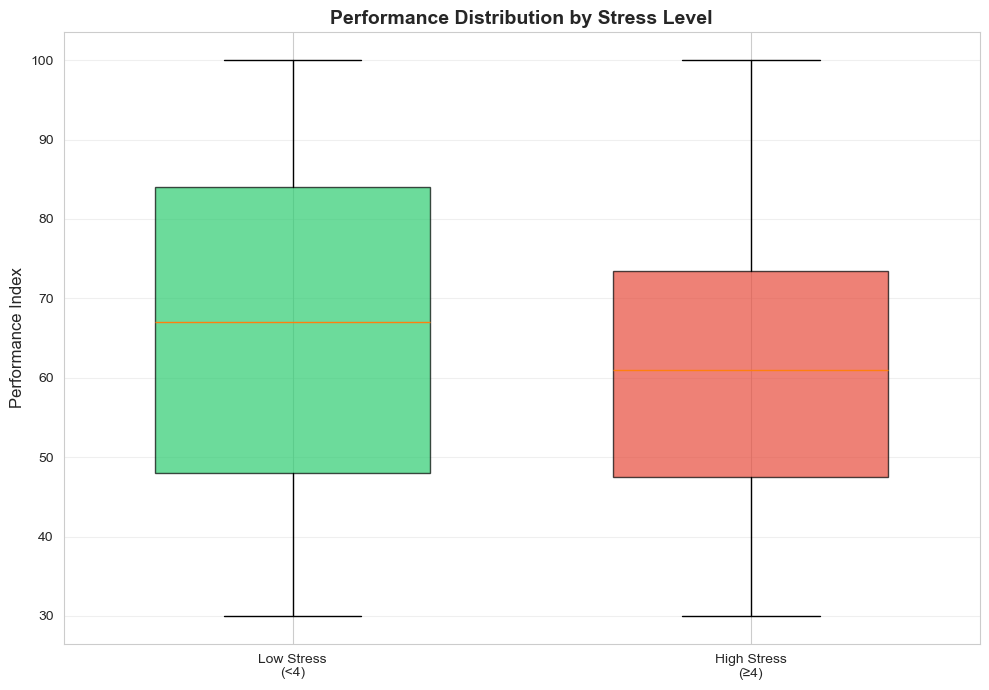

In [11]:
# Box Plot - Performance Distribution by Stress Level
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot([low_stress_perf, high_stress_perf], 
                 labels=['Low Stress\n(<4)', 'High Stress\n(≥4)'],
                 patch_artist=True,
                 widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Performance Index', fontsize=12)
ax.set_title('Performance Distribution by Stress Level', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig7_performance_distribution_by_stress.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Stress X Attrition
- Chi-Square Test for Attrition and Stress
- Attrition Counts by Stress Level
- Attrition Rate by Stress Level

In [12]:
# Attrition rates by stress level
attrition_by_stress = pd.crosstab(df_clean['StressCategory'], df_clean['Attrition'], normalize='index') * 100
print("\nATTRITION RATES BY STRESS LEVEL:")
print(attrition_by_stress.round(2))

# Calculate attrition rate difference
high_stress_attrition = attrition_by_stress.loc['High Stress (≥4)', 'Yes']
low_stress_attrition = attrition_by_stress.loc['Low Stress (<4)', 'Yes']
attrition_diff = high_stress_attrition - low_stress_attrition

print(f"\nKEY METRICS:")
print(f"   High Stress Attrition Rate: {high_stress_attrition:.2f}%")
print(f"   Low Stress Attrition Rate:  {low_stress_attrition:.2f}%")
print(f"   Attrition Risk Increase:    +{attrition_diff:.2f} percentage points")

# Chi-square test for independence
contingency_table = pd.crosstab(df_clean['StressCategory'], df_clean['Attrition'])
chi2, p_value_chi, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nCHI-SQUARE TEST FOR INDEPENDENCE:")
print(f"   Chi-square statistic: {chi2:.4f}")
print(f"   P-value: {p_value_chi:.6f}")
print(f"   Degrees of freedom: {dof}")

if p_value_chi < 0.05:
    print(f"\nSTATISTICALLY SIGNIFICANT FINDING:")
    print(f"   Stress and attrition are NOT independent")
    print(f"   High stress SYSTEMATICALLY increases exit likelihood by {attrition_diff:.1f}pp")
    print(f"   (p < 0.0001 — highly significant)")
else:
    print(f"\nNo significant association found (p = {p_value_chi:.4f})")


ATTRITION RATES BY STRESS LEVEL:
Attrition            No    Yes
StressCategory                
High Stress (≥4)  56.14  43.86
Low Stress (<4)   87.45  12.55

KEY METRICS:
   High Stress Attrition Rate: 43.86%
   Low Stress Attrition Rate:  12.55%
   Attrition Risk Increase:    +31.31 percentage points

CHI-SQUARE TEST FOR INDEPENDENCE:
   Chi-square statistic: 106.8848
   P-value: 0.000000
   Degrees of freedom: 1

STATISTICALLY SIGNIFICANT FINDING:
   Stress and attrition are NOT independent
   High stress SYSTEMATICALLY increases exit likelihood by 31.3pp
   (p < 0.0001 — highly significant)


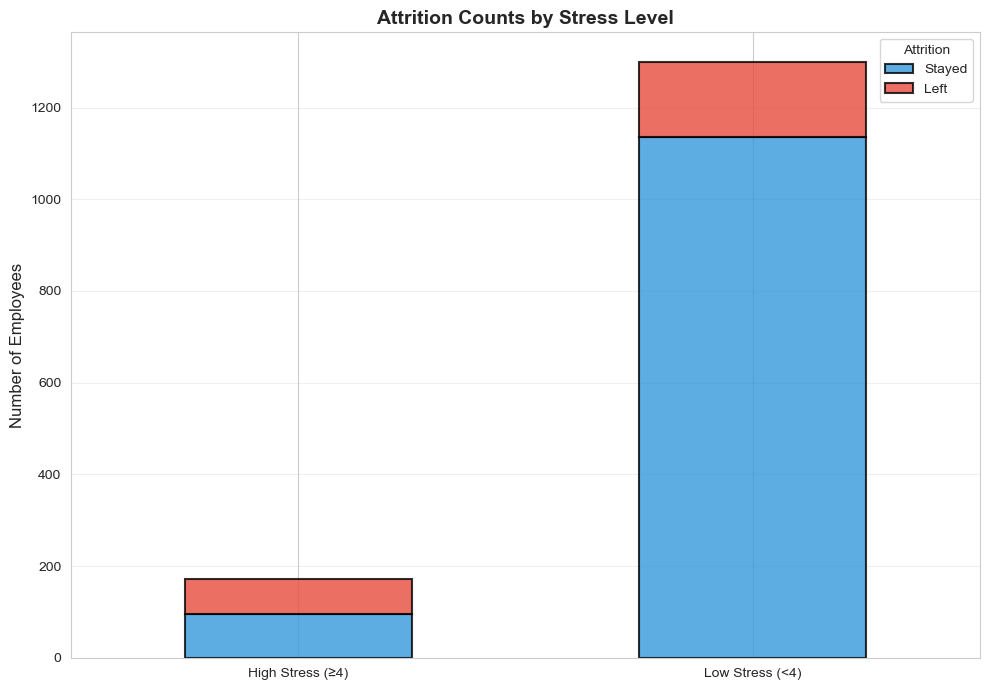

In [13]:
# Stacked Bar Chart - Attrition Counts by Stress Level
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

attrition_counts = pd.crosstab(df_clean['StressCategory'], df_clean['Attrition'])
attrition_counts.plot(kind='bar', stacked=True, color=['#3498db', '#e74c3c'], 
                      ax=ax, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Employees', fontsize=12)
ax.set_xlabel('')
ax.set_title('Attrition Counts by Stress Level', fontsize=14, fontweight='bold')
ax.legend(title='Attrition', labels=['Stayed', 'Left'], fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig9_attrition_counts_by_stress.png', dpi=300, bbox_inches='tight')
plt.show()

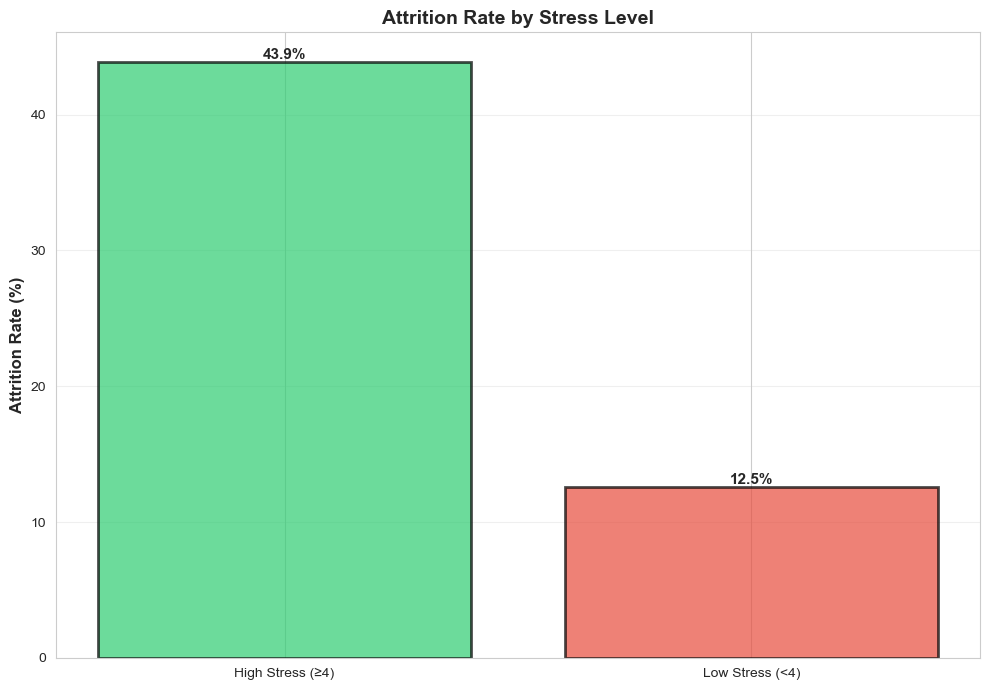

In [14]:
# Attrition Rate by Stress Level
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

attrition_rates = attrition_by_stress['Yes']
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(attrition_rates.index, attrition_rates.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Attrition Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Attrition Rate by Stress Level', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("fig10_attrition_rate_by_stress_level.png", dpi=300, bbox_inches='tight')
plt.show()


---
# Step 3: Feature Engineering

**Objective**: Create meaningful features for ML modeling

**Actions**:
1. Composite Stress Score
2. Interaction Features
3. Tenure & Career Progression Features
4. Categorical Encoding
5. Standardization

In [15]:
# Feature Engineering
df_model = df_clean.copy()

In [16]:
# Composite stress score (weighted average of StressRating and StressSelfReported)
df_model['CompositeStress'] = (df_model['StressRating'] * 0.6 + df_model['StressSelfReported'] * 0.4)

In [17]:
# Interaction features
df_model['Stress_x_OverTime'] = df_model['StressRating'] * df_model['OverTime']
df_model['Stress_x_WorkLifeBalance'] = df_model['StressRating'] * df_model['WorkLifeBalance']
df_model['Stress_x_JobSatisfaction'] = df_model['StressRating'] * df_model['JobSatisfaction']

In [18]:
# Tenure-related features
df_model['TenureRatio'] = df_model['YearsAtCompany'] / (df_model['TotalWorkingYears'] + 1)
df_model['PromotionGap'] = df_model['YearsAtCompany'] - df_model['YearsSinceLastPromotion']

In [19]:
# Income-related features
df_model['IncomePerYear'] = df_model['MonthlyIncome'] / (df_model['TotalWorkingYears'] + 1)

print("✓ Created composite and interaction features")
print(f"\nNew features added:")
print(f"  - CompositeStress")
print(f"  - Stress_x_OverTime")
print(f"  - Stress_x_WorkLifeBalance")
print(f"  - Stress_x_JobSatisfaction")
print(f"  - TenureRatio")
print(f"  - PromotionGap")
print(f"  - IncomePerYear")

print(f"\nDataset shape: {df_model.shape}")

✓ Created composite and interaction features

New features added:
  - CompositeStress
  - Stress_x_OverTime
  - Stress_x_WorkLifeBalance
  - Stress_x_JobSatisfaction
  - TenureRatio
  - PromotionGap
  - IncomePerYear

Dataset shape: (1470, 53)


In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
categorical_cols = ['JobRole', 'Department', 'EducationField', 'MaritalStatus', 
                   'BusinessTravel', 'Gender', 'HowToEmploy']

for col in categorical_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_Encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Encode target variable
df_model['Attrition_Binary'] = (df_model['Attrition'] == 'Yes').astype(int)

print("✓ Categorical variables encoded")
print(f"\nEncoded columns: {len(label_encoders)}")
for col in categorical_cols:
    if col in df_model.columns:
        print(f"  - {col}: {df_model[col].nunique()} unique values")

✓ Categorical variables encoded

Encoded columns: 7
  - JobRole: 9 unique values
  - Department: 3 unique values
  - EducationField: 6 unique values
  - MaritalStatus: 3 unique values
  - BusinessTravel: 3 unique values
  - Gender: 2 unique values
  - HowToEmploy: 6 unique values


---
# Step 4: Handling Class Imbalance

**Objective**: Increase accuracy for models

**Actions**:
1. Define Predictors and Targets for Two Models
1. Check Class Imbalance 
2. SMOTE Technique

In [21]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
from imblearn.over_sampling import SMOTE

# Define features and target for both models

# High Stress Dataset
stress_features = [
    'Age', 'JobLevel', 'WorkLifeBalance', 'OverTime_Binary', 
    'RemoteWork', 'YearsAtCompany', 'JobSatisfaction',
    'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome',
    'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
    'JobRole_Encoded', 'Department_Encoded', 'MaritalStatus_Encoded'
]
stress_features_available = [f for f in stress_features if f in df_model.columns]
X_stress_original = df_model[stress_features_available]
y_stress_original = df_model['HighStress']

# Attrition Dataset
attrition_features = [
    'StressRating', 'CompositeStress', 'PerformanceIndex',
    'JobSatisfaction', 'WorkLifeBalance', 'OverTime_Binary',
    'RemoteWork', 'Age', 'YearsAtCompany', 'MonthlyIncome',
    'JobLevel', 'EnvironmentSatisfaction', 'JobInvolvement',
    'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
    'Stress_x_OverTime', 'Stress_x_WorkLifeBalance',
    'TenureRatio', 'PromotionGap', 'IncomePerYear',
    'JobRole_Encoded', 'Department_Encoded', 'MaritalStatus_Encoded'
]
attrition_features_available = [f for f in attrition_features if f in df_model.columns]
X_attrition_original = df_model[attrition_features_available]
y_attrition_original = df_model['Attrition_Binary']


✓ SMOTE applied successfully
  Before: 1,470 samples
  After: 2,598 samples

  New distribution:
    Class 0: 1,299
    Class 1: 1,299

──────────────────────────────────────────────────────────────────────
APPLYING SMOTE TO ATTRITION MODEL
──────────────────────────────────────────────────────────────────────


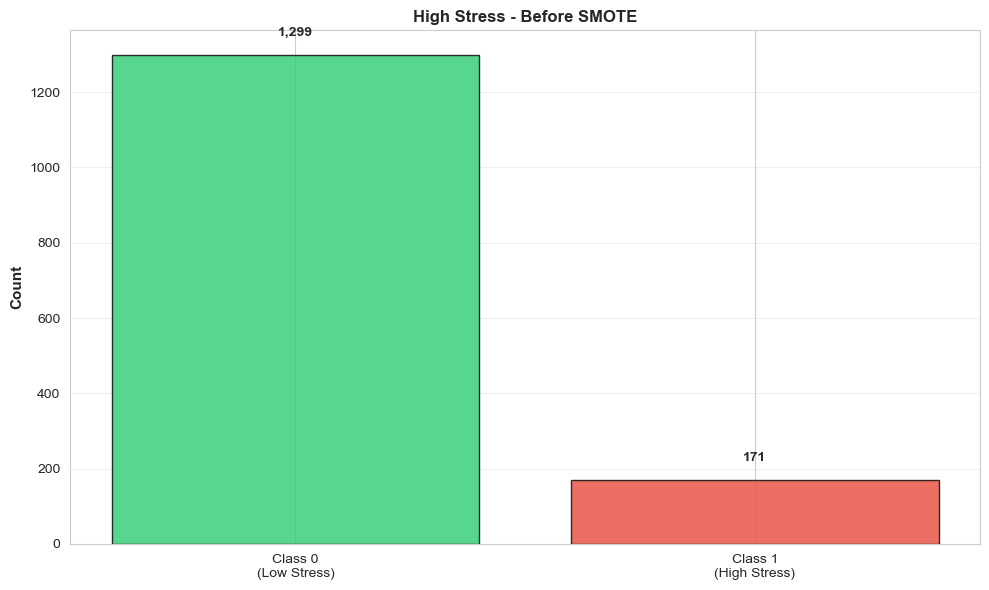

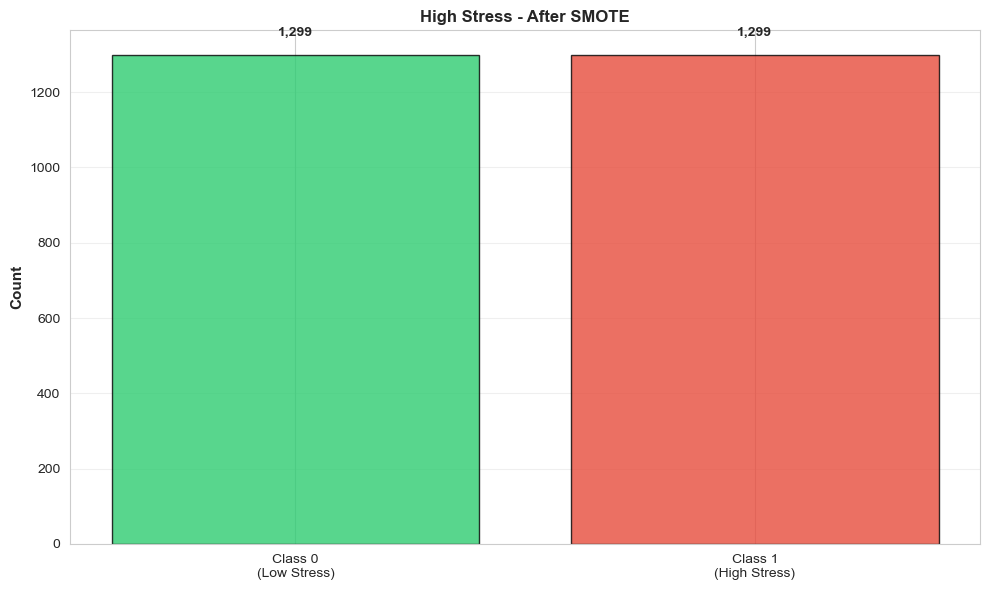

In [23]:
# Stress
smote_stress = SMOTE(random_state=42, k_neighbors=5)
X_stress_resampled, y_stress_resampled = smote_stress.fit_resample(X_stress_original, y_stress_original)

print(f"\n✓ SMOTE applied successfully")
print(f"  Before: {X_stress_original.shape[0]:,} samples")
print(f"  After: {X_stress_resampled.shape[0]:,} samples")
print(f"\n  New distribution:")
print(f"    Class 0: {(y_stress_resampled == 0).sum():,}")
print(f"    Class 1: {(y_stress_resampled == 1).sum():,}")

# Apply SMOTE for Attrition Model
print("\n" + "─"*70)
print("APPLYING SMOTE TO ATTRITION MODEL")
print("─"*70)

# Stress - Before SMOTE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

stress_before = y_stress_original.value_counts()
ax.bar(['Class 0\n(Low Stress)', 'Class 1\n(High Stress)'], 
       stress_before.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('High Stress - Before SMOTE', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(stress_before.values):
    ax.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fig11_high_stress_before_smote.png', dpi=300, bbox_inches='tight')
plt.show()

# Stress - After SMOTE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

stress_after = pd.Series(y_stress_resampled).value_counts()
ax.bar(['Class 0\n(Low Stress)', 'Class 1\n(High Stress)'], 
       stress_after.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('High Stress - After SMOTE', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(stress_after.values):
    ax.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fig12_high_stress_after_smote.png', dpi=300, bbox_inches='tight')
plt.show()


✓ SMOTE applied successfully
  Before: 1,470 samples
  After: 2,464 samples

  New distribution:
    Class 0: 1,232
    Class 1: 1,232


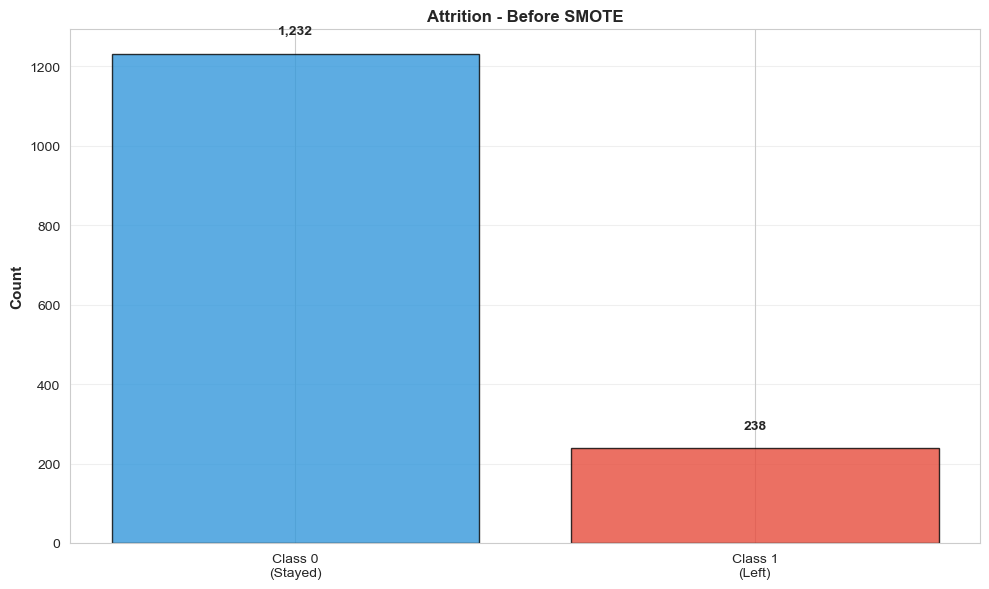

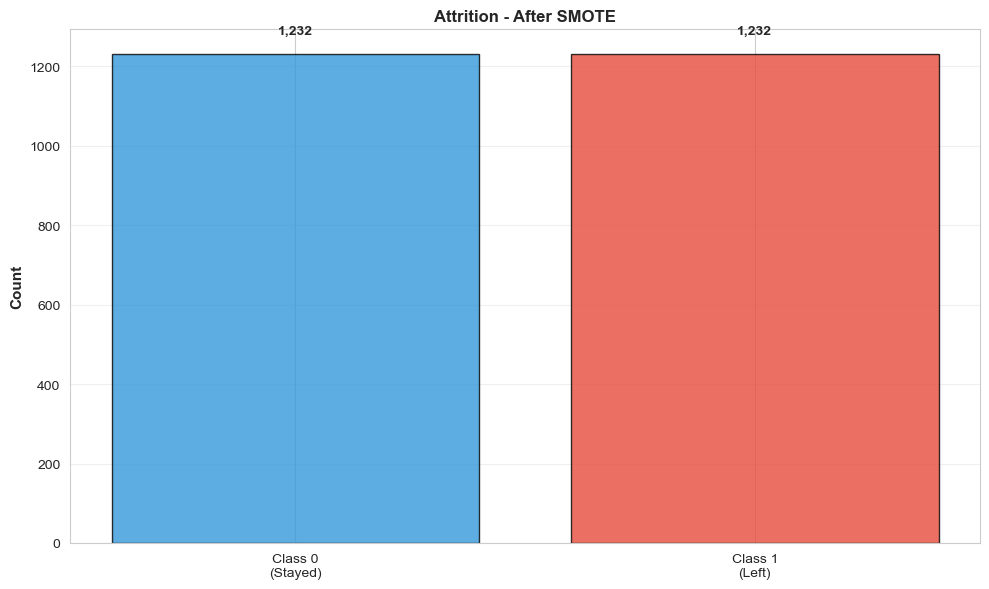

In [24]:
# Attrition 
smote_attrition = SMOTE(random_state=42, k_neighbors=5)
X_attrition_resampled, y_attrition_resampled = smote_attrition.fit_resample(X_attrition_original, y_attrition_original)

print(f"\n✓ SMOTE applied successfully")
print(f"  Before: {X_attrition_original.shape[0]:,} samples")
print(f"  After: {X_attrition_resampled.shape[0]:,} samples")
print(f"\n  New distribution:")
print(f"    Class 0: {(y_attrition_resampled == 0).sum():,}")
print(f"    Class 1: {(y_attrition_resampled == 1).sum():,}")

# Attrition - Before SMOTE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

attrition_before = y_attrition_original.value_counts()
ax.bar(['Class 0\n(Stayed)', 'Class 1\n(Left)'], 
       attrition_before.values, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Attrition - Before SMOTE', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(attrition_before.values):
    ax.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fig13_attrition_before_smote.png', dpi=300, bbox_inches='tight')
plt.show()

# Attrition - After SMOTE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

attrition_after = pd.Series(y_attrition_resampled).value_counts()
ax.bar(['Class 0\n(Stayed)', 'Class 1\n(Left)'], 
       attrition_after.values, color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Attrition - After SMOTE', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(attrition_after.values):
    ax.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fig14_attrition_after_smote.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Step 5: Machine Learning Model Training & Eveluation

**Objective**: Build predictive models for both High Stress and Attrition

We'll develop **two models**:
- **Model A**: Predict High Stress (≥4) → Identify at-risk employees
- **Model B**: Predict Attrition → Quantify retention risk

## Model A: Predicting High Stress

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use the resampled data from SMOTE
X_stress = X_stress_resampled
y_stress = y_stress_resampled

print(f"\nTraining with SMOTE-resampled data:")
print(f"   Total samples: {X_stress.shape[0]:,}")
print(f"   Features: {X_stress.shape[1]}")
print(f"   Class distribution: {pd.Series(y_stress).value_counts().to_dict()}")

# Train-test split (on resampled data)
X_stress_train, X_stress_test, y_stress_train, y_stress_test = train_test_split(
    X_stress, y_stress, test_size=0.2, random_state=42, stratify=y_stress
)

# Standardize features
scaler_stress = StandardScaler()
X_stress_train_scaled = scaler_stress.fit_transform(X_stress_train)
X_stress_test_scaled = scaler_stress.transform(X_stress_test)

# Train Random Forest model (no class_weight needed since data is balanced via SMOTE)
rf_stress = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_stress.fit(X_stress_train_scaled, y_stress_train)

# Predictions
y_stress_pred = rf_stress.predict(X_stress_test_scaled)
y_stress_prob = rf_stress.predict_proba(X_stress_test_scaled)[:, 1]

print(f"\nModel trained successfully")
print(f"   Training set: {X_stress_train.shape[0]:,} samples")
print(f"   Test set: {X_stress_test.shape[0]:,} samples")
print(f"   Features used: {len(stress_features_available)}")


Training with SMOTE-resampled data:
   Total samples: 2,598
   Features: 15
   Class distribution: {1: 1299, 0: 1299}

Model trained successfully
   Training set: 2,078 samples
   Test set: 520 samples
   Features used: 15


In [26]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Evaluation: High Stress Prediction

# Metrics
accuracy_stress = accuracy_score(y_stress_test, y_stress_pred)
f1_stress = f1_score(y_stress_test, y_stress_pred)
roc_auc_stress = roc_auc_score(y_stress_test, y_stress_prob)

print(f"\nAccuracy: {accuracy_stress:.4f} ({accuracy_stress*100:.2f}%)")
print(f"F1-Score: {f1_stress:.4f}")
print(f"ROC-AUC: {roc_auc_stress:.4f}")

print("\n" + "Classification Report:")
print(classification_report(y_stress_test, y_stress_pred, target_names=['Low Stress', 'High Stress']))


Accuracy: 0.8692 (86.92%)
F1-Score: 0.8712
ROC-AUC: 0.9386

Classification Report:
              precision    recall  f1-score   support

  Low Stress       0.88      0.85      0.87       260
 High Stress       0.86      0.88      0.87       260

    accuracy                           0.87       520
   macro avg       0.87      0.87      0.87       520
weighted avg       0.87      0.87      0.87       520




Confusion Matrix:
True Negatives: 222
False Positives: 38
False Negatives: 30
True Positives: 230


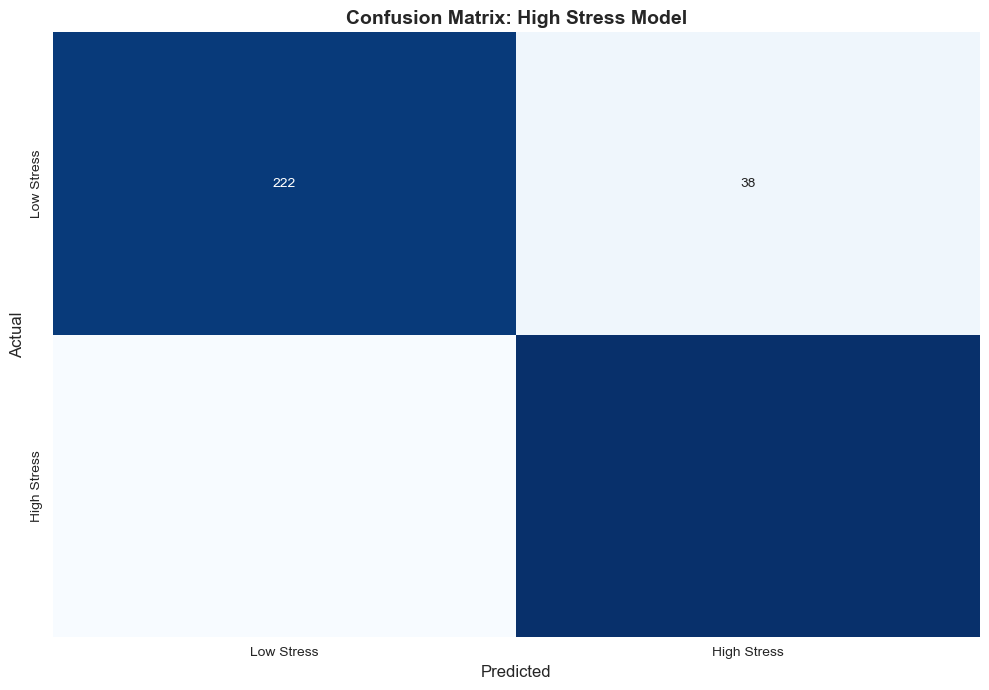

In [27]:
# Confusion Matrix
cm_stress = confusion_matrix(y_stress_test, y_stress_pred)
print("\nConfusion Matrix:")
print(f"True Negatives: {cm_stress[0,0]}")
print(f"False Positives: {cm_stress[0,1]}")
print(f"False Negatives: {cm_stress[1,0]}")
print(f"True Positives: {cm_stress[1,1]}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

sns.heatmap(cm_stress, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix: High Stress Model', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Low Stress', 'High Stress'])
ax.set_yticklabels(['Low Stress', 'High Stress'])

plt.tight_layout()
plt.savefig('fig16_confusion_matrix_stress_model.png', dpi=300, bbox_inches='tight')
plt.show()

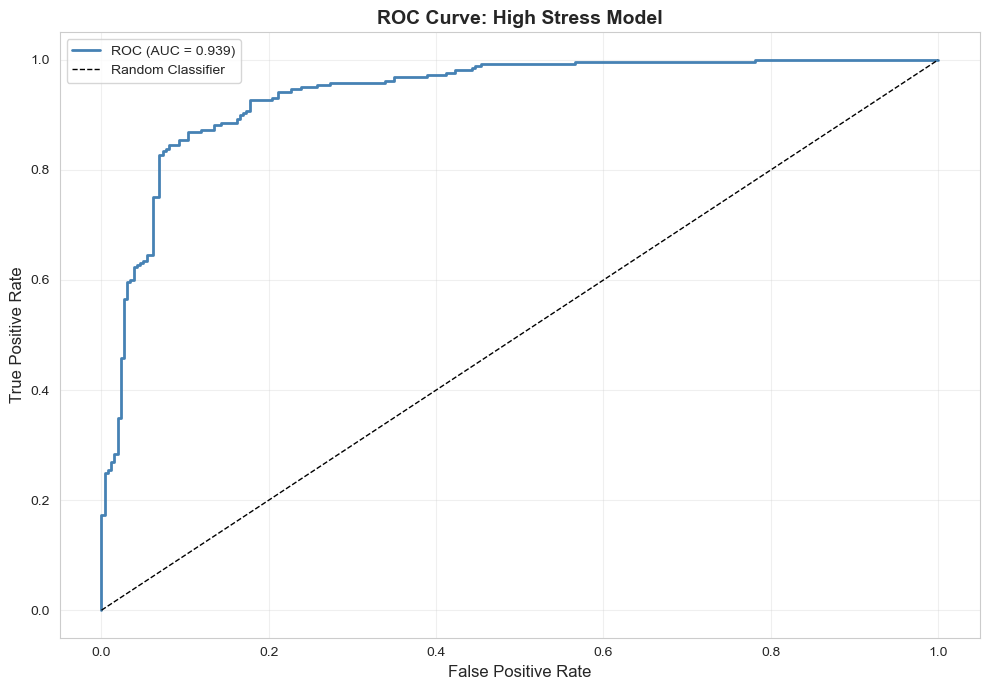

In [28]:
# ROC Curve - High Stress Model
from sklearn.metrics import roc_curve


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

fpr_stress, tpr_stress, _ = roc_curve(y_stress_test, y_stress_prob)
ax.plot(fpr_stress, tpr_stress, color='steelblue', linewidth=2, label=f'ROC (AUC = {roc_auc_stress:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: High Stress Model', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig17_roc_curve_stress_model.png', dpi=300, bbox_inches='tight')
plt.show()


TOP 10 PREDICTORS OF HIGH STRESS
                Feature  Importance
EnvironmentSatisfaction    0.135386
       DistanceFromHome    0.125160
        JobSatisfaction    0.099084
          MonthlyIncome    0.092397
        WorkLifeBalance    0.084291
             RemoteWork    0.059084
      TotalWorkingYears    0.057583
                    Age    0.056091
     NumCompaniesWorked    0.050532
         JobInvolvement    0.049769


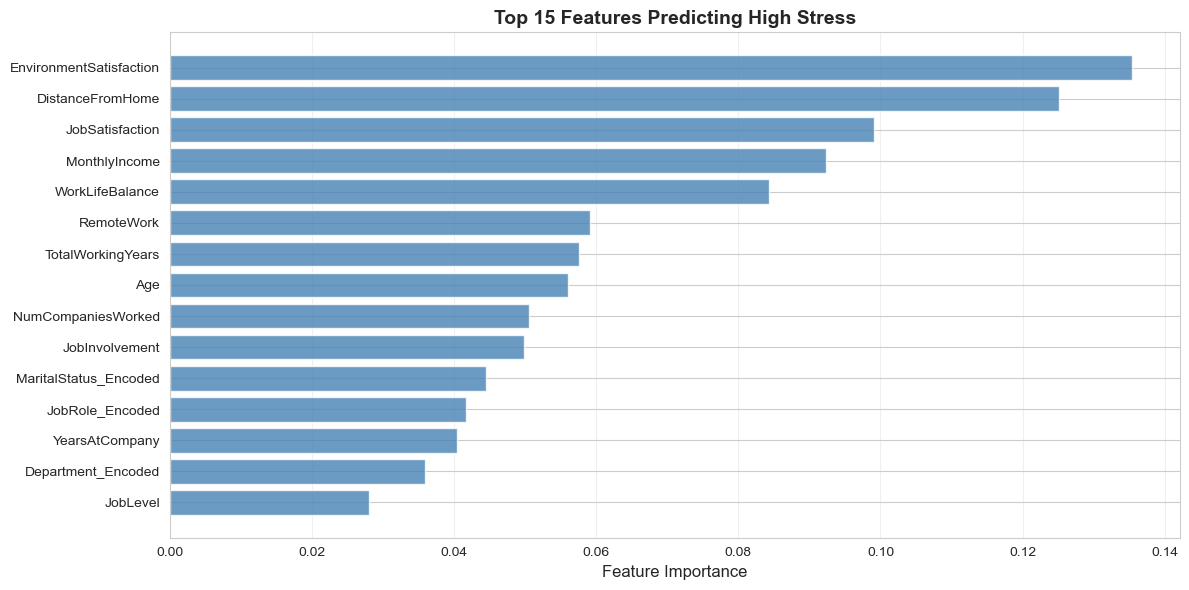

<Figure size 1200x600 with 0 Axes>

In [29]:
# Feature Importance for Stress Model
feature_importance_stress = pd.DataFrame({
    'Feature': stress_features_available,
    'Importance': rf_stress.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 10 PREDICTORS OF HIGH STRESS")
print("="*60)
print(feature_importance_stress.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
top_features_stress = feature_importance_stress.head(15)
plt.barh(top_features_stress['Feature'], top_features_stress['Importance'], color='steelblue', alpha=0.8)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Features Predicting High Stress', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

plt.savefig('fig18_feature_importance_stress_model.png', dpi=300, bbox_inches='tight')

## Model B: Predicting Attrition

In [30]:
X_attrition = X_attrition_resampled
y_attrition = y_attrition_resampled

print(f"\nTraining with SMOTE-resampled data:")
print(f"   Total samples: {X_attrition.shape[0]:,}")
print(f"   Features: {X_attrition.shape[1]}")
print(f"   Class distribution: {pd.Series(y_attrition).value_counts().to_dict()}")

# Train-test split (on resampled data)
X_attr_train, X_attr_test, y_attr_train, y_attr_test = train_test_split(
    X_attrition, y_attrition, test_size=0.2, random_state=42, stratify=y_attrition
)

# Standardize features
scaler_attr = StandardScaler()
X_attr_train_scaled = scaler_attr.fit_transform(X_attr_train)
X_attr_test_scaled = scaler_attr.transform(X_attr_test)

# Train Random Forest model (no class_weight needed since data is balanced via SMOTE)
rf_attrition = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
rf_attrition.fit(X_attr_train_scaled, y_attr_train)

# Predictions
y_attr_pred = rf_attrition.predict(X_attr_test_scaled)
y_attr_prob = rf_attrition.predict_proba(X_attr_test_scaled)[:, 1]


Training with SMOTE-resampled data:
   Total samples: 2,464
   Features: 23
   Class distribution: {1: 1232, 0: 1232}


In [31]:
# Model B Evaluation: Attrition Prediction
print("="*60)
print("MODEL B EVALUATION: ATTRITION PREDICTION")
print("="*60)

# Metrics
accuracy_attr = accuracy_score(y_attr_test, y_attr_pred)
f1_attr = f1_score(y_attr_test, y_attr_pred)
roc_auc_attr = roc_auc_score(y_attr_test, y_attr_prob)

print(f"\nAccuracy: {accuracy_attr:.4f} ({accuracy_attr*100:.2f}%)")
print(f"F1-Score: {f1_attr:.4f}")
print(f"ROC-AUC: {roc_auc_attr:.4f}")

print("\n" + "Classification Report:")
print(classification_report(y_attr_test, y_attr_pred, target_names=['Stayed', 'Left']))

MODEL B EVALUATION: ATTRITION PREDICTION

Accuracy: 0.9026 (90.26%)
F1-Score: 0.9036
ROC-AUC: 0.9638

Classification Report:
              precision    recall  f1-score   support

      Stayed       0.91      0.89      0.90       247
        Left       0.89      0.91      0.90       246

    accuracy                           0.90       493
   macro avg       0.90      0.90      0.90       493
weighted avg       0.90      0.90      0.90       493




Confusion Matrix:
True Negatives (Correctly predicted stays): 220
False Positives (Predicted to leave but stayed): 27
False Negatives (Predicted to stay but left): 21
True Positives (Correctly predicted departures): 225


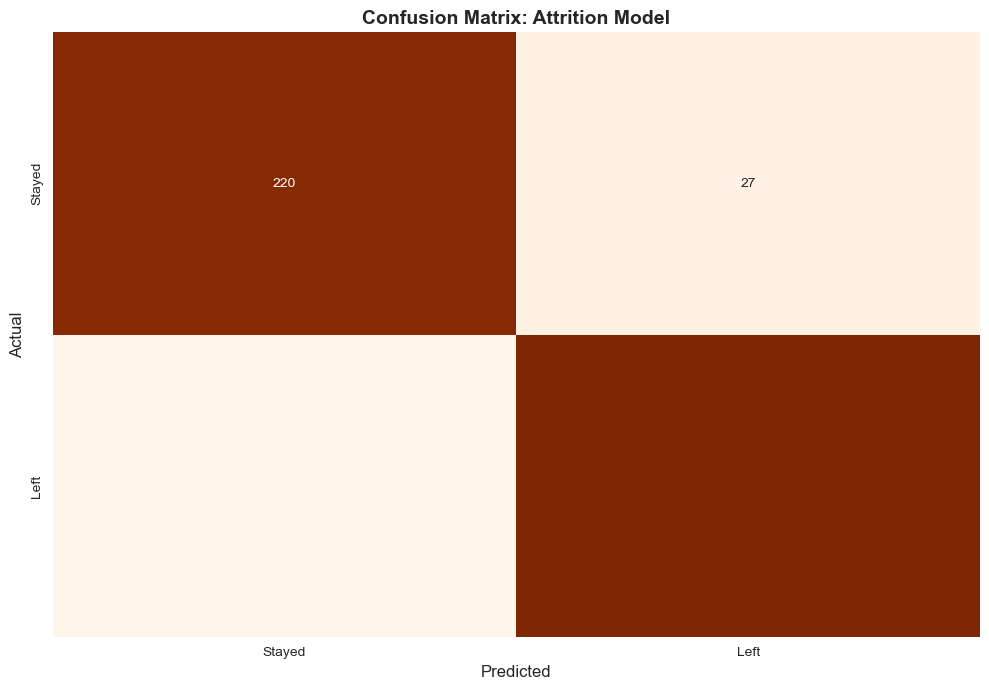

In [32]:
# Confusion Matrix
cm_attr = confusion_matrix(y_attr_test, y_attr_pred)
print("\nConfusion Matrix:")
print(f"True Negatives (Correctly predicted stays): {cm_attr[0,0]}")
print(f"False Positives (Predicted to leave but stayed): {cm_attr[0,1]}")
print(f"False Negatives (Predicted to stay but left): {cm_attr[1,0]}")
print(f"True Positives (Correctly predicted departures): {cm_attr[1,1]}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

sns.heatmap(cm_attr, annot=True, fmt='d', cmap='Oranges', ax=ax, cbar=False)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix: Attrition Model', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Stayed', 'Left'])
ax.set_yticklabels(['Stayed', 'Left'])

plt.tight_layout()
plt.savefig('fig20_confusion_matrix_attrition_model.png', dpi=300, bbox_inches='tight')
plt.show()

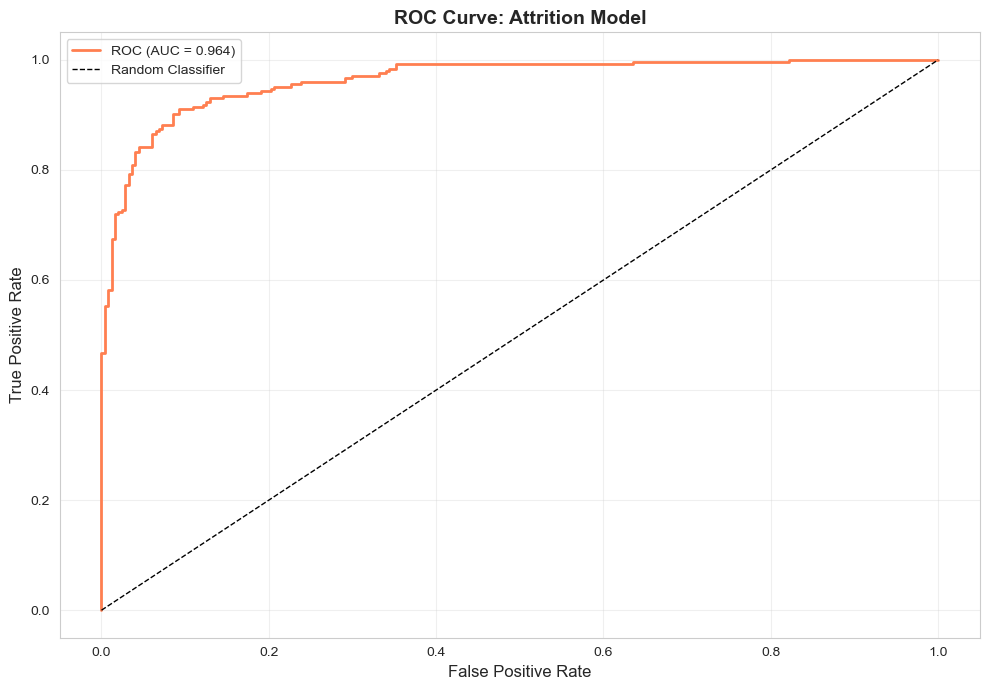

In [41]:
# Visualization 2: ROC Curve - Attrition Model
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

fpr_attr, tpr_attr, _ = roc_curve(y_attr_test, y_attr_prob)
ax.plot(fpr_attr, tpr_attr, color='coral', linewidth=2, label=f'ROC (AUC = {roc_auc_attr:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Attrition Model', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig21_roc_curve_attrition_model.png', dpi=300, bbox_inches='tight')
plt.show()


TOP 10 PREDICTORS OF ATTRITION
                Feature  Importance
               JobLevel    0.082510
        CompositeStress    0.082392
          MonthlyIncome    0.065621
        JobSatisfaction    0.065591
            TenureRatio    0.063096
EnvironmentSatisfaction    0.053188
           PromotionGap    0.050482
         JobInvolvement    0.048730
      TotalWorkingYears    0.047345
          IncomePerYear    0.047216


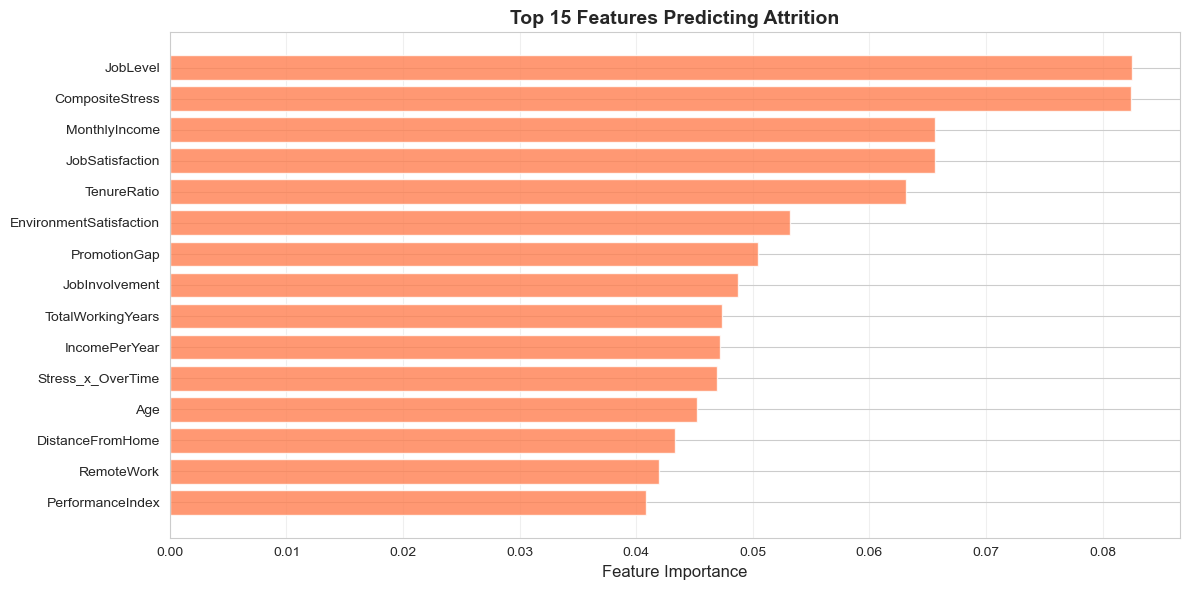

<Figure size 1200x600 with 0 Axes>

In [34]:
# Feature Importance for Attrition Model
feature_importance_attr = pd.DataFrame({
    'Feature': attrition_features_available,
    'Importance': rf_attrition.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 10 PREDICTORS OF ATTRITION")
print("="*60)
print(feature_importance_attr.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
top_features_attr = feature_importance_attr.head(15)
plt.barh(top_features_attr['Feature'], top_features_attr['Importance'], color='coral', alpha=0.8)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Features Predicting Attrition', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

plt.savefig("fig19_feature_importance_attrition_predictor", dpi=300, bbox_inches='tight')

---
# Step 6: Quantify Business Impact

**Objective**: Translate ML findings into financial value

**Approach**:
1. Estimate attrition cost per employee
2. Simulate stress-reduction scenario
3. Calculate cost savings from reduced attrition
4. Quantify performance gains from lower stress

In [35]:
# Business Impact Assumptions
print("="*60)
print("BUSINESS IMPACT CALCULATION")
print("="*60)

# Key assumptions (industry standard)
AVG_ANNUAL_SALARY = df_clean['MonthlyIncome'].median() * 12
ATTRITION_COST_MULTIPLIER = 0.50  # Conservative: 0.50x annual salary for replacement costs
ATTRITION_COST_PER_EMPLOYEE = AVG_ANNUAL_SALARY * ATTRITION_COST_MULTIPLIER

# Current workforce metrics
TOTAL_EMPLOYEES = len(df_clean)
HIGH_STRESS_COUNT = (df_clean['HighStress'] == 1).sum()
HIGH_STRESS_PCT = (HIGH_STRESS_COUNT / TOTAL_EMPLOYEES) * 100

# Current attrition statistics
CURRENT_ATTRITION_COUNT = (df_clean['Attrition'] == 'Yes').sum()
CURRENT_ATTRITION_RATE = (CURRENT_ATTRITION_COUNT / TOTAL_EMPLOYEES) * 100

print(f"\nCURRENT STATE:")
print(f"   Total Employees: {TOTAL_EMPLOYEES:,}")
print(f"   High Stress Employees: {HIGH_STRESS_COUNT:,} ({HIGH_STRESS_PCT:.1f}%)")
print(f"   Current Attrition: {CURRENT_ATTRITION_COUNT:,} employees ({CURRENT_ATTRITION_RATE:.1f}%)")
print(f"\nCOST ASSUMPTIONS:")
print(f"   Median Annual Salary: ${AVG_ANNUAL_SALARY:,.0f}")
print(f"   Attrition Cost Multiplier: {ATTRITION_COST_MULTIPLIER}x")
print(f"   Cost per Attrition: ${ATTRITION_COST_PER_EMPLOYEE:,.0f}")
print(f"\n   CURRENT ANNUAL ATTRITION COST: ${CURRENT_ATTRITION_COUNT * ATTRITION_COST_PER_EMPLOYEE:,.0f}")

BUSINESS IMPACT CALCULATION

CURRENT STATE:
   Total Employees: 1,470
   High Stress Employees: 171 (11.6%)
   Current Attrition: 238 employees (16.2%)

COST ASSUMPTIONS:
   Median Annual Salary: $81,774
   Attrition Cost Multiplier: 0.5x
   Cost per Attrition: $40,887

   CURRENT ANNUAL ATTRITION COST: $9,731,106


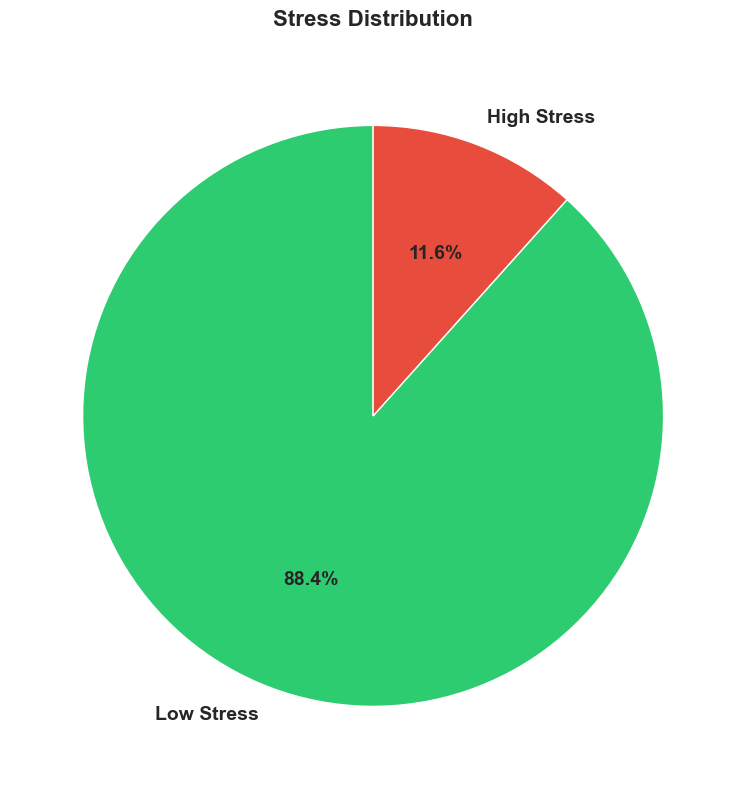

In [36]:
# High Stress Distribution
fig1 = plt.figure(figsize=(8, 8))
stress_counts = df_clean['HighStress'].value_counts()
colors_stress = ['#2ecc71', '#e74c3c']
plt.pie(stress_counts, labels=['Low Stress', 'High Stress'], autopct='%1.1f%%',
       colors=colors_stress, startangle=90, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title('Stress Distribution', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig23_chart1_stress_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

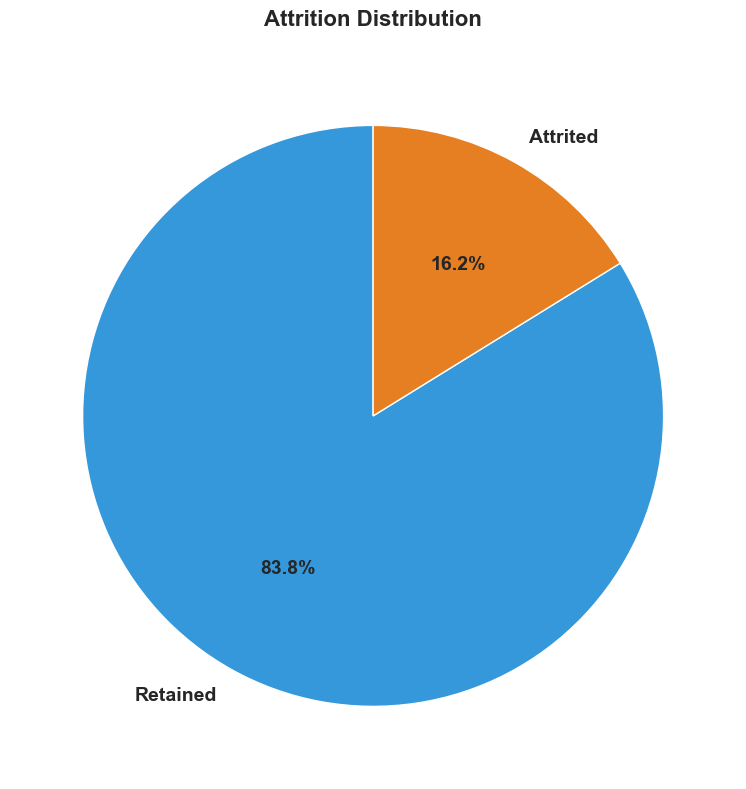

In [37]:
# Slide 9 - Chart 2: Attrition Distribution
fig2 = plt.figure(figsize=(8, 8))
attrition_counts = df_clean['Attrition'].value_counts()
colors_attrition = ['#3498db', '#e67e22']
plt.pie(attrition_counts, labels=['Retained', 'Attrited'], autopct='%1.1f%%',
       colors=colors_attrition, startangle=90, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title('Attrition Distribution', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig24_chart2_attrition_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Annual Salary Statistics:
   Overall: Mean=$83,067, Median=$81,774
   Low Stress: Mean=$83,556, Median=$82,356
   High Stress: Mean=$79,351, Median=$77,832


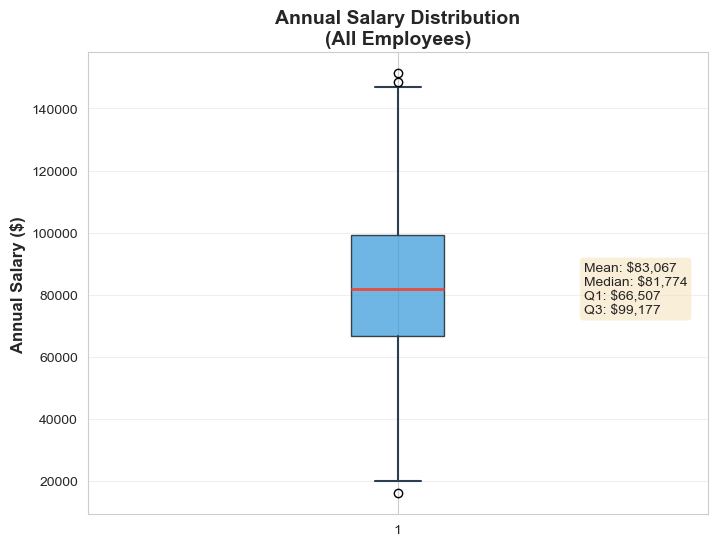

In [38]:
# Box Plot - Annual Salary Distribution

# Calculate annual salary
df_clean['AnnualSalary'] = df_clean['MonthlyIncome'] * 12

# Create box plot for annual salary
fig = plt.figure(figsize=(8, 6))

bp = plt.boxplot(df_clean['AnnualSalary'], 
                  vert=True, 
                  patch_artist=True,
                  boxprops=dict(facecolor='#3498db', alpha=0.7),
                  medianprops=dict(color='#e74c3c', linewidth=2),
                  whiskerprops=dict(color='#2c3e50', linewidth=1.5),
                  capprops=dict(color='#2c3e50', linewidth=1.5))

plt.ylabel('Annual Salary ($)', fontsize=12, fontweight='bold')
plt.title('Annual Salary Distribution\n(All Employees)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add statistics
q1 = df_clean['AnnualSalary'].quantile(0.25)
q2 = df_clean['AnnualSalary'].median()
q3 = df_clean['AnnualSalary'].quantile(0.75)
mean_salary = df_clean['AnnualSalary'].mean()

stats_text = f'Mean: ${mean_salary:,.0f}\nMedian: ${q2:,.0f}\nQ1: ${q1:,.0f}\nQ3: ${q3:,.0f}'
plt.text(1.3, q2, stats_text, fontsize=10, va='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('fig25_annual_salary_distribution.png', dpi=300, bbox_inches='tight')

# Print summary statistics
print(f"\nAnnual Salary Statistics:")
print(f"   Overall: Mean=${mean_salary:,.0f}, Median=${q2:,.0f}")
print(f"   Low Stress: Mean=${df_clean[df_clean['HighStress'] == 0]['AnnualSalary'].mean():,.0f}, Median=${df_clean[df_clean['HighStress'] == 0]['AnnualSalary'].median():,.0f}")
print(f"   High Stress: Mean=${df_clean[df_clean['HighStress'] == 1]['AnnualSalary'].mean():,.0f}, Median=${df_clean[df_clean['HighStress'] == 1]['AnnualSalary'].median():,.0f}")

In [39]:
# Scenario Analysis: Stress Reduction Impact
print("\n" + "="*60)
print("SCENARIO: REDUCE HIGH STRESS BY 50%")
print("="*60)

# Get attrition rates by stress level
high_stress_attr_rate = (df_clean[df_clean['HighStress'] == 1]['Attrition'] == 'Yes').mean()
low_stress_attr_rate = (df_clean[df_clean['HighStress'] == 0]['Attrition'] == 'Yes').mean()

print(f"\n📊 ATTRITION RATES:")
print(f"   High Stress: {high_stress_attr_rate*100:.1f}%")
print(f"   Low Stress: {low_stress_attr_rate*100:.1f}%")

# Scenario: Move 50% of high-stress employees to low-stress
EMPLOYEES_TO_IMPROVE = HIGH_STRESS_COUNT // 2
NEW_HIGH_STRESS_COUNT = HIGH_STRESS_COUNT - EMPLOYEES_TO_IMPROVE
NEW_LOW_STRESS_COUNT = (TOTAL_EMPLOYEES - HIGH_STRESS_COUNT) + EMPLOYEES_TO_IMPROVE

# Calculate new expected attritions
CURRENT_HIGH_STRESS_ATTRITIONS = HIGH_STRESS_COUNT * high_stress_attr_rate
CURRENT_LOW_STRESS_ATTRITIONS = (TOTAL_EMPLOYEES - HIGH_STRESS_COUNT) * low_stress_attr_rate
CURRENT_TOTAL_ATTRITIONS = CURRENT_HIGH_STRESS_ATTRITIONS + CURRENT_LOW_STRESS_ATTRITIONS

NEW_HIGH_STRESS_ATTRITIONS = NEW_HIGH_STRESS_COUNT * high_stress_attr_rate
NEW_LOW_STRESS_ATTRITIONS = NEW_LOW_STRESS_COUNT * low_stress_attr_rate
NEW_TOTAL_ATTRITIONS = NEW_HIGH_STRESS_ATTRITIONS + NEW_LOW_STRESS_ATTRITIONS

ATTRITIONS_PREVENTED = CURRENT_TOTAL_ATTRITIONS - NEW_TOTAL_ATTRITIONS
COST_SAVINGS = ATTRITIONS_PREVENTED * ATTRITION_COST_PER_EMPLOYEE

print(f"\nINTERVENTION IMPACT:")
print(f"   Employees improved (stress reduced): {EMPLOYEES_TO_IMPROVE:,}")
print(f"   Expected attritions prevented: {ATTRITIONS_PREVENTED:.1f}")
print(f"\nANNUAL COST SAVINGS: ${COST_SAVINGS:,.0f}")
print(f"   ROI: {(COST_SAVINGS / (CURRENT_ATTRITION_COUNT * ATTRITION_COST_PER_EMPLOYEE)) * 100:.1f}% reduction in attrition costs")


SCENARIO: REDUCE HIGH STRESS BY 50%

📊 ATTRITION RATES:
   High Stress: 43.9%
   Low Stress: 12.5%

INTERVENTION IMPACT:
   Employees improved (stress reduced): 85
   Expected attritions prevented: 26.6

ANNUAL COST SAVINGS: $1,088,200
   ROI: 11.2% reduction in attrition costs


In [40]:
# ROI Calculation

INVESTMENT = 300000 # Estimated cost of stress reduction initiatives

roi = (COST_SAVINGS / INVESTMENT) * 100
print(f"\nRETURN ON INVESTMENT (ROI) FROM STRESS REDUCTION INITIATIVE: {roi:.1f}%")


RETURN ON INVESTMENT (ROI) FROM STRESS REDUCTION INITIATIVE: 362.7%
